In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import random

In [2]:
# Сначала определим на каком устройстве будем работать - GPU или CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
# Параметр train указывает какую часть набора будем загружать (True - обучающую, False - тестовую)
# Параметр transform указывает какие преобразования с данными необходимо проделать
# это могут быть обрезка, повороты, изменения яркасти и др.

In [5]:
train_dataset = datasets.ImageFolder(root='animals/train', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(root='animals/val', transform=data_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# посмотрим какие классы содержатся в наборе
train_dataset.classes
# сохраним названия этих классов
class_names = train_dataset.classes
# каждая итерация обращения к созданному DataLoader возвращает batch данных и их классы
inputs, classes = next(iter(train_loader))
inputs.shape
classes

tensor([1, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1,
        2, 2, 0, 2, 0, 0, 2, 0])

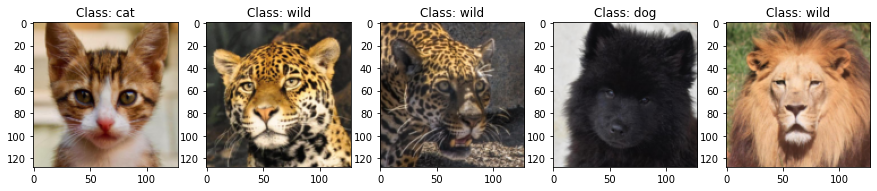

In [7]:
# Функция для отображения случайной выборки
def show_random_samples(dataset, num_samples=5):
    class_names = dataset.classes
    # Получаем случайные индексы из тренировочного датасета
    random_indices = random.sample(range(len(dataset)), num_samples)
    # Создаем подзагрузчик данных для случайной выборки
    random_loader = DataLoader(dataset, batch_size=num_samples, sampler=SubsetRandomSampler(random_indices))
    # Получаем один батч из случайной выборки
    images, labels = next(iter(random_loader))
    # Преобразование тензоров в изображения
    images = images.numpy()
    # Вывод изображений
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i].set_title(f'Class: {class_names[labels[i].item()]}')
    plt.show()

# Используйте функцию, передавая ваш тренировочный датасет
show_random_samples(train_dataset, num_samples=5)

In [8]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 32 * 32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [9]:
# Зададим количество эпох обучения (каждая эпоха прогоняет обучающий набор 1 раз)
num_epochs = 2
num_classes = 3

# создаем экземпляр сети
net = ConvNet(num_classes).to(device)

# Задаем функцию потерь и алгоритм оптимизации
lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)


In [ ]:
# создаем цикл обучения и замеряем время его выполнения
import time
t = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # прямой проход
        outputs = net(images)
        # вычисление значения функции потерь
        loss = lossFn(outputs, labels)
        # Обратный проход (вычисляем градиенты)
        optimizer.zero_grad()
        loss.backward()
        # делаем шаг оптимизации весов
        optimizer.step()
        # выводим немного диагностической информации
        if i%100==0:
            print('Эпоха ' + str(epoch) + ' из ' + str(num_epochs) + ' Шаг ' +
                  str(i) + ' Ошибка: ', loss.item())
            
print(time.time() - t)

In [ ]:
# посчитаем точность нашей модели: количество правильно классифицированных изображений
# поделенное на общее количество тестовых примеров

correct_predictions = 0
num_test_samples = len(val_dataset)
with torch.no_grad(): # отключим вычисление граиентов, т.к. будем делать только прямой проход
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred = net(images) # делаем предсказание по пакету
        _, pred_class = torch.max(pred.data, 1) # выбираем класс с максимальной оценкой
        correct_predictions += (pred_class == labels).sum().item()
print('Точность модели: ' + str(100 * correct_predictions / num_test_samples) + '%')

In [ ]:
# Нашу модель можно сохранить в файл для дальнейшего использования
torch.save(net.state_dict(), 'CnNet.ckpt')

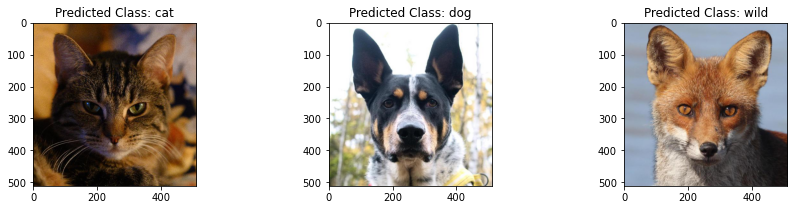

In [12]:
from PIL import Image
model = ConvNet().to(device)
model.load_state_dict(torch.load("CnNet.ckpt"))
model.eval()
# Путь к вашему изображению
images = ['animals/val/cat/flickr_cat_000011.jpg',
          'animals/val/dog/flickr_dog_000141.jpg',
          'animals/val/wild/flickr_wild_000064.jpg']

# Загрузка изображения
fig, axes = plt.subplots(1, len(images), figsize=(15, 3))

for image_path, i in zip(images, range(len(images))):
    image = Image.open(image_path)

    # Применение трансформаций к изображению
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    # Преобразование изображения и добавление размерности пакета
    input_image = transform(image).unsqueeze(0)

    # Передача изображения через модель
    model.eval()  # Установка модели в режим оценки (выключение режима обучения)
    with torch.no_grad():
        input_image = input_image.to(device)
        output = model(input_image)
    # Получение предсказания
    _, predicted_class = torch.max(output, 1)
    predicted_class = predicted_class.item()
    # Вывод результата
    class_names = train_dataset.classes  # Замените на свои классы
    predicted_class_name = class_names[predicted_class]
    # Вывод изображения и предсказания
    axes[i].imshow(np.asarray(image))
    axes[i].set_title(f'Predicted Class: {predicted_class_name}')
plt.show()